Train shape: (35744, 8)
Test shape:  (41702, 8)
Validation shape: (41702, 8)

Train label distribution:
label
1    20373
0    15371
Name: count, dtype: int64

Validation label distribution:
label
1    23769
0    17933
Name: count, dtype: int64

Test label distribution:
label
1    23770
0    17932
Name: count, dtype: int64
Xtr columns: ['text', 'word_count', 'sentence_count', 'words_per_sentence', 'domain']
Xtr shape: (35744, 5)

================ Logistic Regression ================
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'clf__C': 10, 'preprocess__text__max_features': 50000, 'preprocess__text__ngram_range': (1, 2)}
Best CV F1: 0.9861758839031904


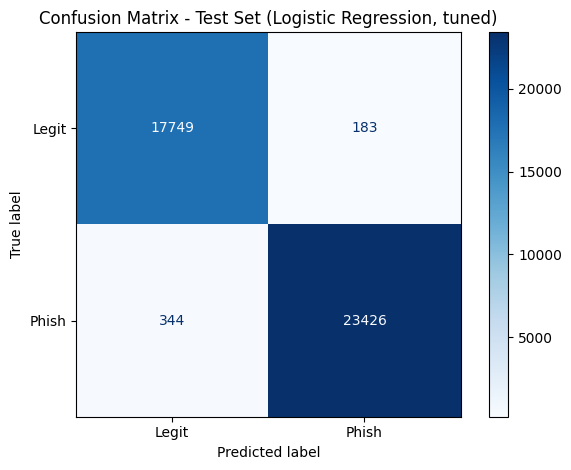

Tuned Test F1: 0.9888769285970578
Tuned Test report:
              precision    recall  f1-score   support

           0      0.981     0.990     0.985     17932
           1      0.992     0.986     0.989     23770

    accuracy                          0.987     41702
   macro avg      0.987     0.988     0.987     41702
weighted avg      0.987     0.987     0.987     41702



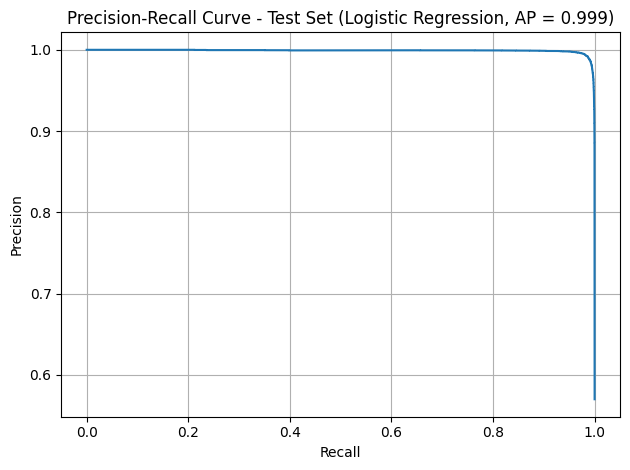

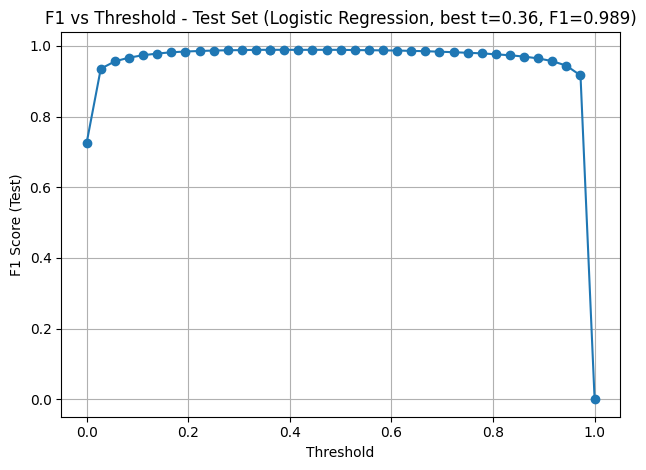

Saved model for Logistic Regression to models\logistic_regression.joblib
Saved best threshold for Logistic Regression to models\logistic_regression_threshold.txt


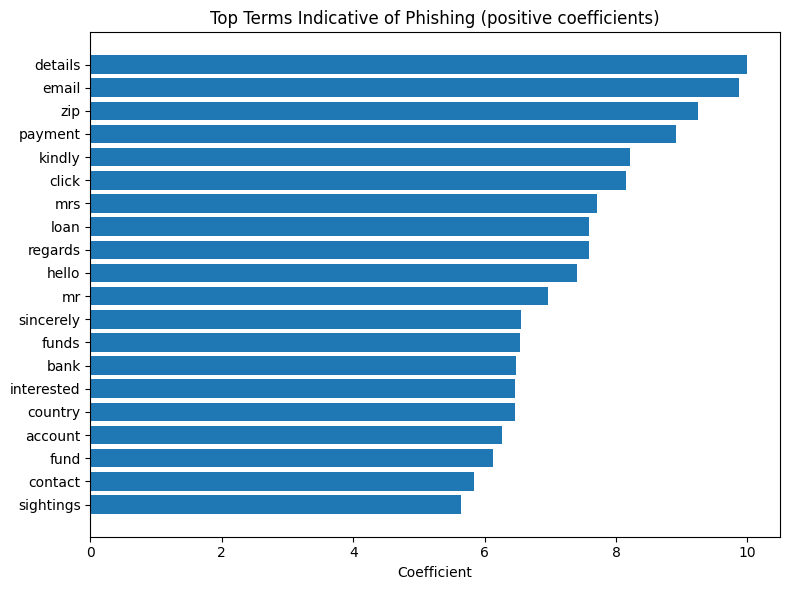

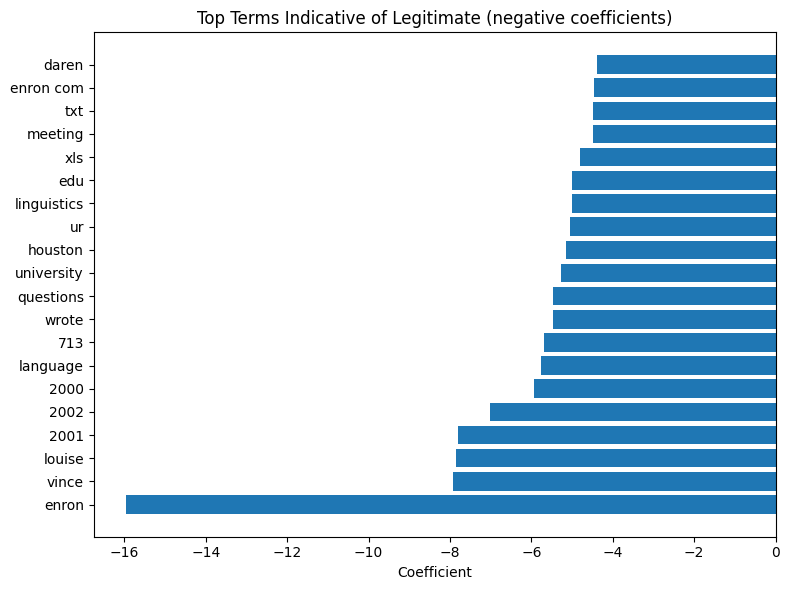


================ Linear SVM ================
Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\hadin\Downloads\Uni\CU\1st Semester\COMP 6321\Project\phishing_ml_new\venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'clf__C': 1, 'preprocess__text__max_features': 100000, 'preprocess__text__ngram_range': (1, 2)}
Best CV F1: 0.9873950747781852


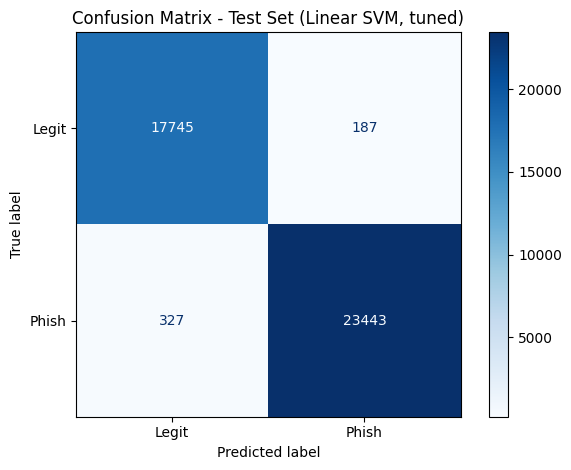

Tuned Test F1: 0.9891561181434599
Tuned Test report:
              precision    recall  f1-score   support

           0      0.982     0.990     0.986     17932
           1      0.992     0.986     0.989     23770

    accuracy                          0.988     41702
   macro avg      0.987     0.988     0.987     41702
weighted avg      0.988     0.988     0.988     41702



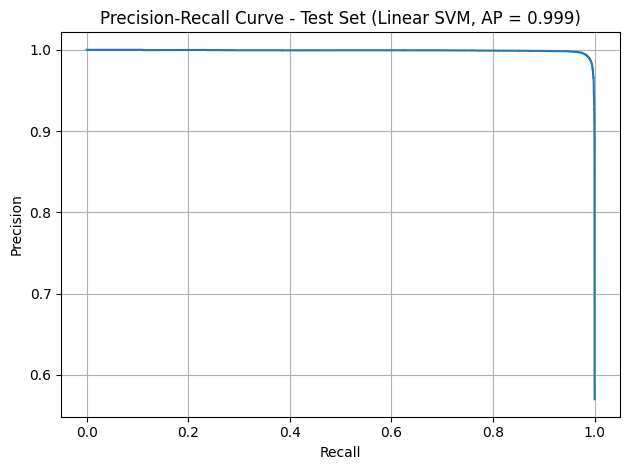

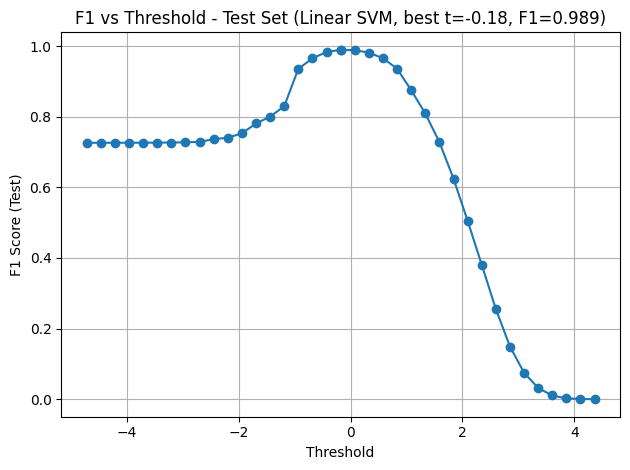

Saved model for Linear SVM to models\linear_svm.joblib
Saved best threshold for Linear SVM to models\linear_svm_threshold.txt

================ Random Forest ================
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
Best CV F1: 0.9809996288989596


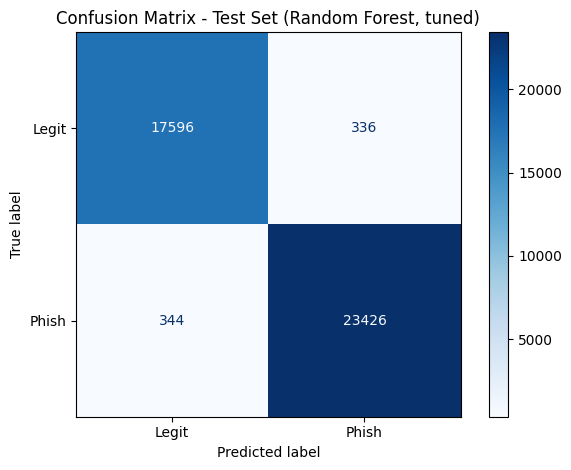

Tuned Test F1: 0.9856938483547926
Tuned Test report:
              precision    recall  f1-score   support

           0      0.981     0.981     0.981     17932
           1      0.986     0.986     0.986     23770

    accuracy                          0.984     41702
   macro avg      0.983     0.983     0.983     41702
weighted avg      0.984     0.984     0.984     41702



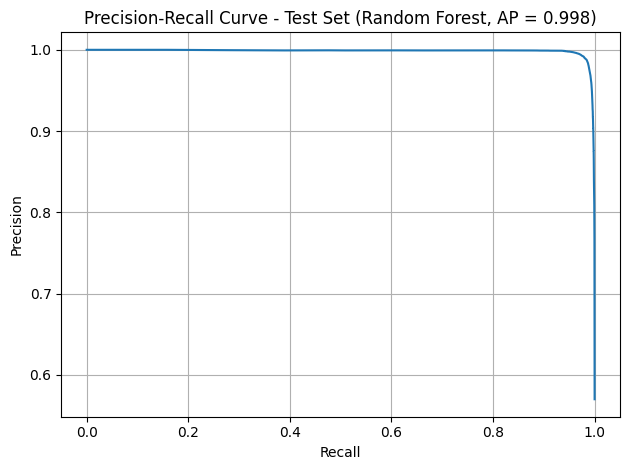

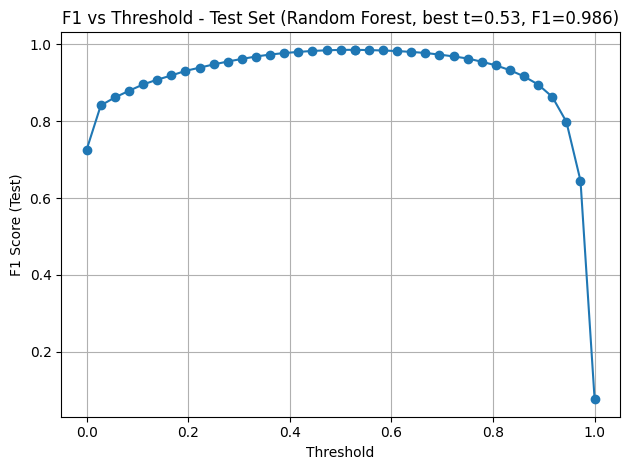

Saved model for Random Forest to models\random_forest.joblib
Saved best threshold for Random Forest to models\random_forest_threshold.txt

================ Naive Bayes ================
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params: {'clf__alpha': 0.1, 'preprocess__text__max_features': 100000, 'preprocess__text__ngram_range': (1, 2)}
Best CV F1: 0.980835718610433


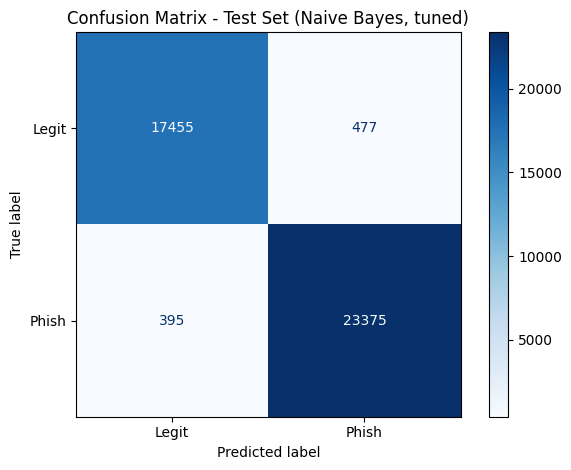

Tuned Test F1: 0.981689135273613
Tuned Test report:
              precision    recall  f1-score   support

           0      0.978     0.973     0.976     17932
           1      0.980     0.983     0.982     23770

    accuracy                          0.979     41702
   macro avg      0.979     0.978     0.979     41702
weighted avg      0.979     0.979     0.979     41702



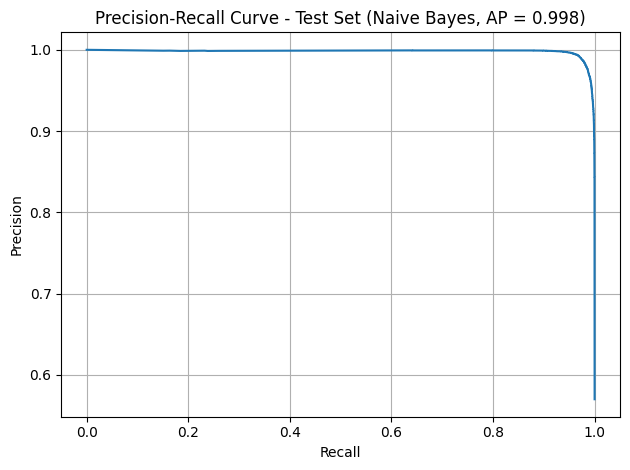

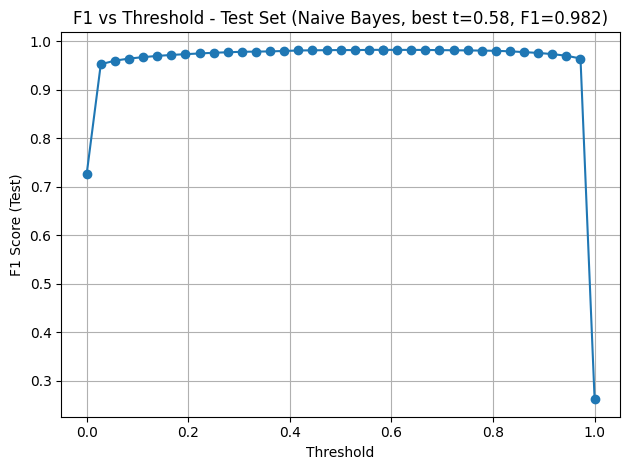

Saved model for Naive Bayes to models\naive_bayes.joblib
Saved best threshold for Naive Bayes to models\naive_bayes_threshold.txt

=== Summary over all models (Test set) ===
                 Model  Accuracy  Precision  Recall     F1  PR-AUC  \
0  Logistic Regression     0.987      0.992   0.986  0.989   0.999   
1           Linear SVM     0.988      0.992   0.986  0.989   0.999   
2        Random Forest     0.984      0.986   0.986  0.986   0.998   
3          Naive Bayes     0.979      0.980   0.983  0.982   0.998   

   Best_threshold  Best_threshold_F1  
0           0.361              0.989  
1          -0.177              0.989  
2           0.528              0.986  
3           0.583              0.982  

Saved: results/all_models_metrics.json


In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    average_precision_score, precision_recall_curve,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

#1 Load data
train_df = pd.read_csv("data/train.csv")
test_df  = pd.read_csv("data/test.csv")
val_df   = pd.read_csv("data/val.csv")

print("Train shape:", train_df.shape)
print("Test shape: ", test_df.shape)
print("Validation shape:", val_df.shape)

print("\nTrain label distribution:")
print(train_df["label"].value_counts())

print("\nValidation label distribution:")
print(val_df["label"].value_counts())

print("\nTest label distribution:")
print(test_df["label"].value_counts())

#2 Define X/y for training, testing, validation
feature_cols = ["text", "word_count", "sentence_count", "words_per_sentence", "domain"]

Xtr = train_df[feature_cols].copy()
ytr = train_df["label"].astype(int)

Xte = test_df[feature_cols].copy()
yte = test_df["label"].astype(int)

Xva = val_df[feature_cols].copy()
yva = val_df["label"].astype(int)

print("Xtr columns:", Xtr.columns.tolist())
print("Xtr shape:", Xtr.shape)

#column names
text_col = "text"
num_cols = ["word_count", "sentence_count", "words_per_sentence"]
cat_cols = ["domain"]

#3 Preprocessing pipeline
preprocess = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            lowercase=True,
            stop_words="english",
            ngram_range=(1, 2),
            min_df=2,
            max_features=100_000
        ), text_col),
        ("num", StandardScaler(with_mean=False), num_cols),
        ("domain", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)


#4 Models and hyperparameter grids
models = {
    "Logistic Regression": LogisticRegression(
        C=10.0,
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    ),
    "Linear SVM": LinearSVC(
        C=1.0,
        class_weight="balanced"
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced_subsample"
    ),
    "Naive Bayes": MultinomialNB()
}

param_grids = {
    "Logistic Regression": {
        "preprocess__text__ngram_range": [(1, 1), (1, 2)],
        "preprocess__text__max_features": [50_000, 100_000],
        "clf__C": [0.1, 1, 10]
    },
    "Linear SVM": {
        "preprocess__text__ngram_range": [(1, 1), (1, 2)],
        "preprocess__text__max_features": [50_000, 100_000],
        "clf__C": [0.1, 1, 10]
    },
    "Random Forest": {
        "clf__n_estimators": [100, 300],
        "clf__max_depth": [None, 20, 40],
        "clf__min_samples_split": [2, 5]
    },
    "Naive Bayes": {
        "preprocess__text__ngram_range": [(1, 1), (1, 2)],
        "preprocess__text__max_features": [50_000, 100_000],
        "clf__alpha": [0.1, 1.0]
    }
}

#5 Helpers
def slugify(name: str) -> str:
    return name.lower().replace(" ", "_")

def plot_top_terms(coefs, feature_names, top_n=20, title=""):
    idx = np.argsort(coefs)[-top_n:]
    terms = feature_names[idx]
    vals  = coefs[idx]

    plt.figure(figsize=(8, 6))
    y = np.arange(top_n)
    plt.barh(y, vals)
    plt.yticks(y, terms)
    plt.xlabel("Coefficient")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_bottom_terms(coefs, feature_names, top_n=20, title=""):
    idx = np.argsort(coefs)[:top_n]
    terms = feature_names[idx]
    vals  = coefs[idx]

    plt.figure(figsize=(8, 6))
    y = np.arange(top_n)
    plt.barh(y, vals)
    plt.yticks(y, terms)
    plt.xlabel("Coefficient")
    plt.title(title)
    plt.tight_layout()
    plt.show()

#6 Create folders + metrics container
Path("models").mkdir(exist_ok=True)
Path("results").mkdir(exist_ok=True)

metrics_list = []

#7 Main loop over models
for name, clf in models.items():
    print(f"\n================ {name} ================")

    # Base pipeline
    base_pipe = Pipeline([
        ("preprocess", preprocess),
        ("clf", clf)
    ])

    #grid search
    grid = param_grids[name]
    gs = GridSearchCV(
        base_pipe,
        grid,
        scoring="f1",
        n_jobs=-1,
        cv=3,
        verbose=1
    )
    gs.fit(Xtr, ytr)

    print("Best params:", gs.best_params_)
    print("Best CV F1:", gs.best_score_)

    #best model
    best_pipe = gs.best_estimator_

    #test predictions
    test_pred = best_pipe.predict(Xte)

    #scores for PR/threshold
    if hasattr(best_pipe, "predict_proba"):
        test_scores = best_pipe.predict_proba(Xte)[:, 1]
    elif hasattr(best_pipe, "decision_function"):
        test_scores = best_pipe.decision_function(Xte)
    else:
        test_scores = test_pred.astype(float)

    # confusion matrix
    cm = confusion_matrix(yte, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["Legit", "Phish"])
    disp.plot(values_format="d", cmap="Blues")
    plt.title(f"Confusion Matrix - Test Set ({name}, tuned)")
    plt.tight_layout()
    plt.show()

    print("Tuned Test F1:", f1_score(yte, test_pred))
    print("Tuned Test report:")
    print(classification_report(yte, test_pred, digits=3))

    #precision–recall
    prec, rec, _ = precision_recall_curve(yte, test_scores)
    ap = average_precision_score(yte, test_scores)

    plt.figure()
    plt.plot(rec, prec)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - Test Set ({name}, AP = {ap:.3f})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #F1 vs threshold
    ths = np.linspace(test_scores.min(), test_scores.max(), 37)
    f1s = [f1_score(yte, (test_scores >= t).astype(int)) for t in ths]

    plt.figure()
    plt.plot(ths, f1s, marker="o")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score (Test)")
    best_i = int(np.argmax(f1s))
    best_thr = float(ths[best_i])
    best_f1 = float(f1s[best_i])
    plt.scatter([best_thr], [best_f1])
    plt.title(f"F1 vs Threshold - Test Set ({name}, best t={best_thr:.2f}, F1={best_f1:.3f})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #metrics row
    metrics_list.append({
        "Model": name,
        "Accuracy": accuracy_score(yte, test_pred),
        "Precision": precision_score(yte, test_pred),
        "Recall": recall_score(yte, test_pred),
        "F1": f1_score(yte, test_pred),
        "PR-AUC": ap,
        "Best_threshold": best_thr,
        "Best_threshold_F1": best_f1
    })

    #save model + threshold
    safe_name = slugify(name)
    model_path = Path("models") / f"{safe_name}.joblib"
    thr_path   = Path("models") / f"{safe_name}_threshold.txt"

    from joblib import dump
    dump(best_pipe, model_path)
    thr_path.write_text(str(best_thr))

    print(f"Saved model for {name} to {model_path}")
    print(f"Saved best threshold for {name} to {thr_path}")

    #coefficient plots only for Logistic Regression
    if name == "Logistic Regression":
        #TfidfVectorizer inside ColumnTransformer
        tfidf = best_pipe.named_steps["preprocess"].named_transformers_["text"]
        lr_clf = best_pipe.named_steps["clf"]

        feature_names = tfidf.get_feature_names_out()
        #take only coefficients corresponding to text features
        coefs = lr_clf.coef_[0][:len(feature_names)]

        plot_top_terms(
            coefs, feature_names, top_n=20,
            title="Top Terms Indicative of Phishing (positive coefficients)"
        )
        plot_bottom_terms(
            coefs, feature_names, top_n=20,
            title="Top Terms Indicative of Legitimate (negative coefficients)"
        )

#8 Summary + metrics JSON
summary = pd.DataFrame(metrics_list)
print("\n=== Summary over all models (Test set) ===")
print(summary.round(3))

metrics_json = {}
for row in metrics_list:
    name = row["Model"]
    metrics_json[name] = {
        "accuracy": float(row["Accuracy"]),
        "precision": float(row["Precision"]),
        "recall": float(row["Recall"]),
        "f1": float(row["F1"]),
        "pr_auc": float(row["PR-AUC"]),
        "best_threshold": float(row["Best_threshold"]),
        "best_threshold_f1": float(row["Best_threshold_F1"])
    }

(Path("results") / "all_models_metrics.json").write_text(
    json.dumps(metrics_json, indent=2)
)

print("\nSaved: results/all_models_metrics.json")
